## 1. Import Libraries

In [70]:
import math
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
import matplotlib.pyplot as plt
import joblib
import warnings
warnings.filterwarnings("ignore")

## 2. Load Train and Test Data

In [89]:
# Carga los datos desde los archivos guardados
X_train = np.load("data/X_train.npy")
y_train = np.load("data/y_train.npy")
X_test = np.load("data/X_test.npy")
y_test = np.load("data/y_test.npy")
scaler = joblib.load("data/scaler.pkl")
dates = np.load("data/dates.npy")
train_close_len = np.load("data/train_close_len.npy")

## 3. Designing our LSTM

### 3.1. Simple LSTM

In [25]:
# Modelo simple con una sola capa LSTM
model = Sequential()

# Capa LSTM sin return_sequences, para que solo devuelva la última salida
model.add(LSTM(units=512, activation='relu', input_shape=(X_train.shape[1], 1)))

# Capa densa final para predecir un único valor
model.add(Dense(units=1))

# Ver estructura del modelo
model.summary()

# Compilar el modelo
model.compile(optimizer="Adam", loss="mean_squared_error", metrics=['mae'])

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_10 (LSTM)                  │ (None, 512)            │     1,052,672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,053,185 (4.02 MB)

 Trainable params: 1,053,185 (4.02 MB)

 Non-trainable params: 0 (0.00 B)

In [26]:
# Entrenar el modelo
model.fit(X_train, y_train,
          epochs=3,
          batch_size=100, 
          verbose=1)

Epoch 1/3
521/521 ━━━━━━━━━━━━━━━━━━━━ 198s 379ms/step - loss: 0.0024 - mae: 0.0167
Epoch 2/3
521/521 ━━━━━━━━━━━━━━━━━━━━ 189s 362ms/step - loss: 1.7862e-05 - mae: 0.0026
Epoch 3/3
521/521 ━━━━━━━━━━━━━━━━━━━━ 186s 356ms/step - loss: 1.6157e-05 - mae: 0.0025


In [27]:
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)

408/408 ━━━━━━━━━━━━━━━━━━━━ 22s 54ms/step


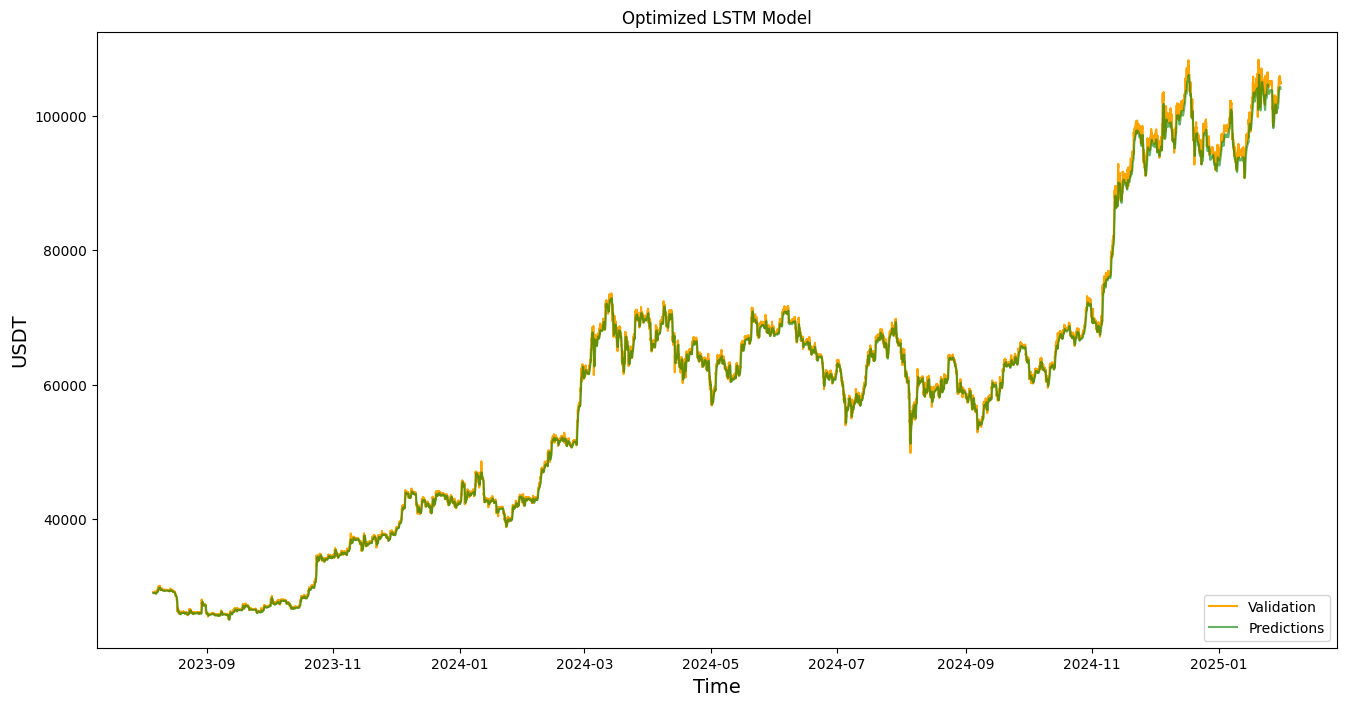

In [ ]:
# plot the data
train = scaler.inverse_transform(y_train.reshape(-1, 1))
valid = scaler.inverse_transform(y_test.reshape(-1, 1))
#visualize the data
plt.figure(figsize=(16, 8))
plt.title("Optimized LSTM Model")
plt.xlabel("Time", fontsize=14)
plt.ylabel("USDT", fontsize=14)
plt.plot(dates[train_close_len:], valid, color="orange")
plt.plot(dates[train_close_len:], predictions, alpha=0.6, color="green")
plt.legend(["Validation", "Predictions"], loc="lower right")
plt.show()

In [29]:
mse1 = np.mean(np.square(valid - predictions))
rmse1 = math.sqrt(mse1)
mae1 = np.mean(np.abs(valid - predictions))
print(f"Mean Squared Error: {mse1}")
print(f"Root Mean Squared Error: {rmse1}")
print(f"Mean Absolute Error: {mae1}")

Mean Squared Error: 572452.6405108559
Root Mean Squared Error: 756.6060008424834
Mean Absolute Error: 498.980573367691


### 3.2. Double LSTM Layers

In [30]:
# Construye el modelo LSTM pre-optimizado
model = Sequential()

# Primera capa LSTM con 512 neuronas y salida de secuencia activada
model.add(LSTM(units=512, return_sequences=True, activation='relu', input_shape=(X_train.shape[1], 1)))

# Segunda capa LSTM con 256 neuronas, sin devolver secuencias
model.add(LSTM(units=256, activation='relu', return_sequences=False))

# Capa densa final que genera la predicción
model.add(Dense(units=1))

# Muestra la estructura del modelo
model.summary()

# Compilar el modelo
model.compile(optimizer="Adam", loss="mean_squared_error", metrics=['mae'])

c:\Users\germa\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_11 (LSTM)                  │ (None, 168, 512)       │     1,052,672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_12 (LSTM)                  │ (None, 256)            │       787,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,840,385 (7.02 MB)

 Trainable params: 1,840,385 (7.02 MB)

 Non-trainable params: 0 (0.00 B)

In [31]:
# Entrenar el modelo
model.fit(X_train, y_train,
          epochs=3,
          batch_size=100, 
          verbose=1)

Epoch 1/3
521/521 ━━━━━━━━━━━━━━━━━━━━ 378s 724ms/step - loss: 0.0020 - mae: 0.0143
Epoch 2/3
521/521 ━━━━━━━━━━━━━━━━━━━━ 374s 718ms/step - loss: 2.7871e-05 - mae: 0.0033
Epoch 3/3
521/521 ━━━━━━━━━━━━━━━━━━━━ 376s 722ms/step - loss: 2.2098e-05 - mae: 0.0030


In [ ]:
popredictions = model.predict(X_test)
popredictions = scaler.inverse_transform(popredictions)

408/408 ━━━━━━━━━━━━━━━━━━━━ 37s 92ms/step


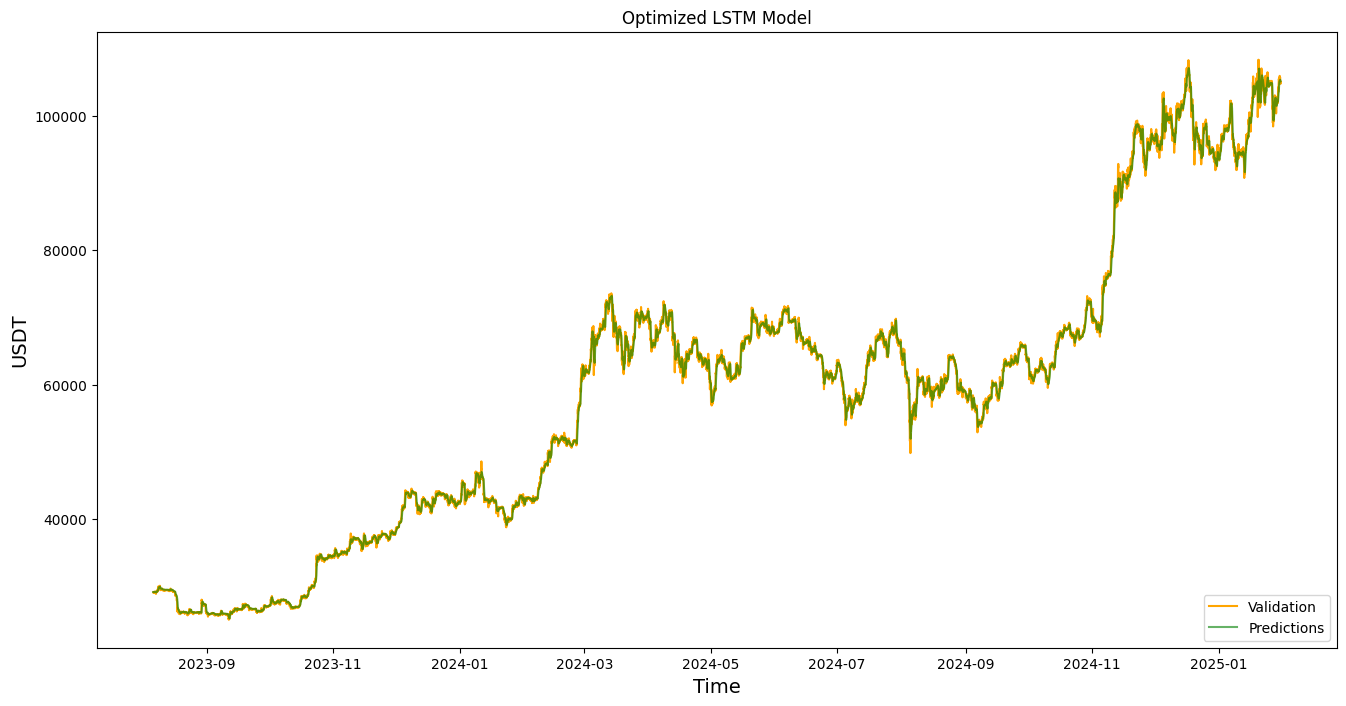

In [73]:
# plot the data
train = scaler.inverse_transform(y_train.reshape(-1, 1))
valid = scaler.inverse_transform(y_test.reshape(-1, 1))
#visualize the data
plt.figure(figsize=(16, 8))
plt.title("Optimized LSTM Model")
plt.xlabel("Time", fontsize=14)
plt.ylabel("USDT", fontsize=14)
plt.plot(dates[train_close_len:], valid, color="orange")
plt.plot(dates[train_close_len:], popredictions, alpha=0.6, color="green")
plt.legend(["Validation", "Predictions"], loc="lower right")
plt.show()

In [46]:
mse2 = np.mean(np.square(valid - popredictions))
rmse2 = math.sqrt(mse2)
mae2 = np.mean(np.abs(valid - popredictions))
print(f"Mean Squared Error: {mse2}")
print(f"Root Mean Squared Error: {rmse2}")
print(f"Mean Absolute Error: {mae2}")

Mean Squared Error: 425555.23597575526
Root Mean Squared Error: 652.3459480795104
Mean Absolute Error: 403.72298428639175


### 3.3. Optimized LSTM

In [90]:
# Construye el modelo LSTM optimizado
optimized_model = Sequential()

# Primera capa LSTM con 50 neuronas, manteniendo la salida de secuencia activa
optimized_model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)))

# Segunda capa LSTM con 100 neuronas, sin devolver secuencias
optimized_model.add(LSTM(100, return_sequences=False))

# Capa densa intermedia con 50 neuronas
optimized_model.add(Dense(50))

# Capa densa final que genera la predicción
optimized_model.add(Dense(1))

# Muestra la estructura del modelo
optimized_model.summary()

# Compilar el modelo
optimized_model.compile(optimizer="adam", loss="mean_squared_error", metrics=['mae'])

Model: "sequential_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_25 (LSTM)                  │ (None, 168, 50)        │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_26 (LSTM)                  │ (None, 100)            │        60,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 50)             │         5,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 75,901 (296.49 KB)

 Trainable params: 75,901 (296.49 KB)

 Non-trainable params: 0 (0.00 B)

In [91]:
# Entrenar el modelo
model.fit(X_train, y_train,
          epochs=3,
          batch_size=100, 
          verbose=1)

Epoch 1/3
521/521 ━━━━━━━━━━━━━━━━━━━━ 457s 877ms/step - loss: 9.6294e-06 - mae: 0.0019
Epoch 2/3
521/521 ━━━━━━━━━━━━━━━━━━━━ 409s 784ms/step - loss: 1.1356e-05 - mae: 0.0021
Epoch 3/3
521/521 ━━━━━━━━━━━━━━━━━━━━ 606s 1s/step - loss: 9.6696e-06 - mae: 0.0020


In [77]:
optimized_model.save_weights("optimized_model.weights.h5")

In [94]:
optimized_model.load_weights("optimized_model.weights.h5")

In [95]:
# Predict with optimized LSTM model
o_predictions = optimized_model.predict(X_test)
o_predictions = scaler.inverse_transform(o_predictions)

408/408 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step


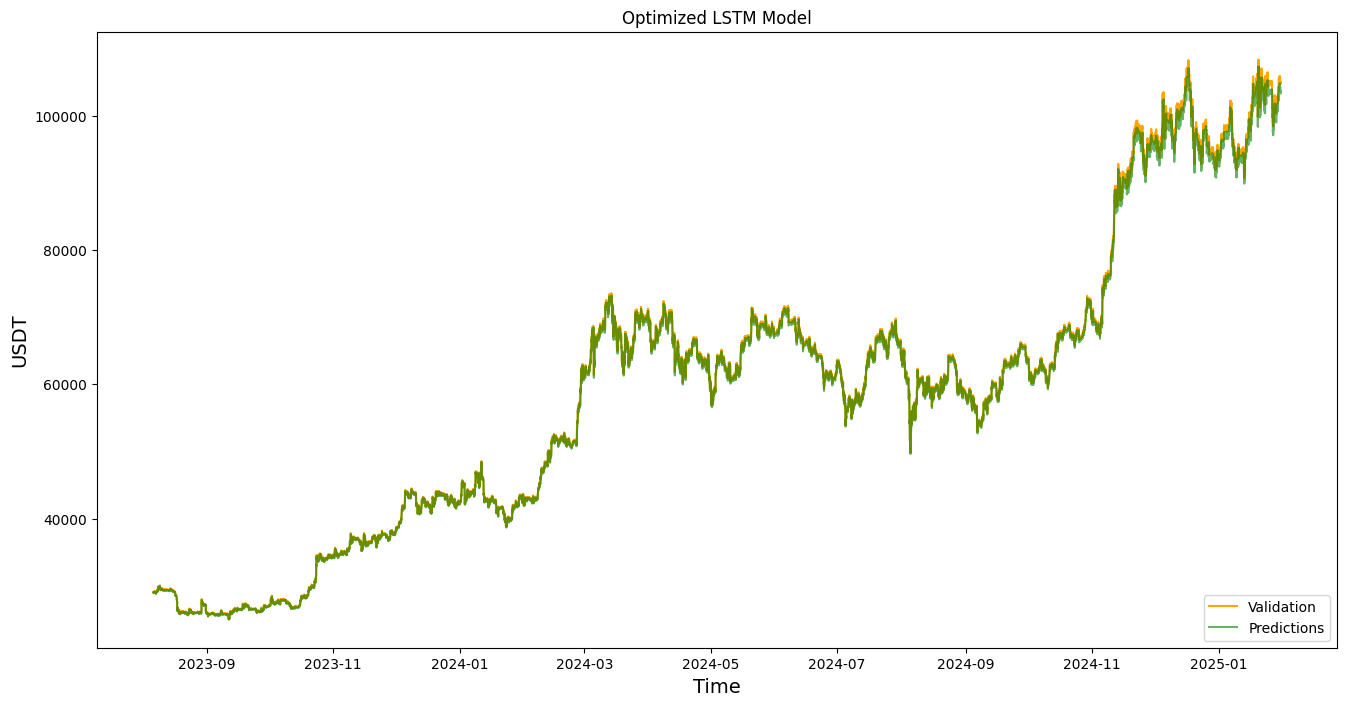

In [96]:
# plot the data
train = scaler.inverse_transform(y_train.reshape(-1, 1))
valid = scaler.inverse_transform(y_test.reshape(-1, 1))
#visualize the data
plt.figure(figsize=(16, 8))
plt.title("Optimized LSTM Model")
plt.xlabel("Time", fontsize=14)
plt.ylabel("USDT", fontsize=14)
plt.plot(dates[train_close_len:], valid, color="orange")
plt.plot(dates[train_close_len:], o_predictions, alpha=0.6, color="green")
plt.legend(["Validation", "Predictions"], loc="lower right")
plt.show()

In [97]:
mse3 = np.mean(np.square(valid - o_predictions))
rmse3 = math.sqrt(mse3)
mae3 = np.mean(np.abs(valid - o_predictions))
print(f"Mean Squared Error: {mse3}")
print(f"Root Mean Squared Error: {rmse3}")
print(f"Mean Absolute Error: {mae3}")

Mean Squared Error: 340389.8031067295
Root Mean Squared Error: 583.4293471421621
Mean Absolute Error: 395.3174279039582


## 4. Metrics Comparison

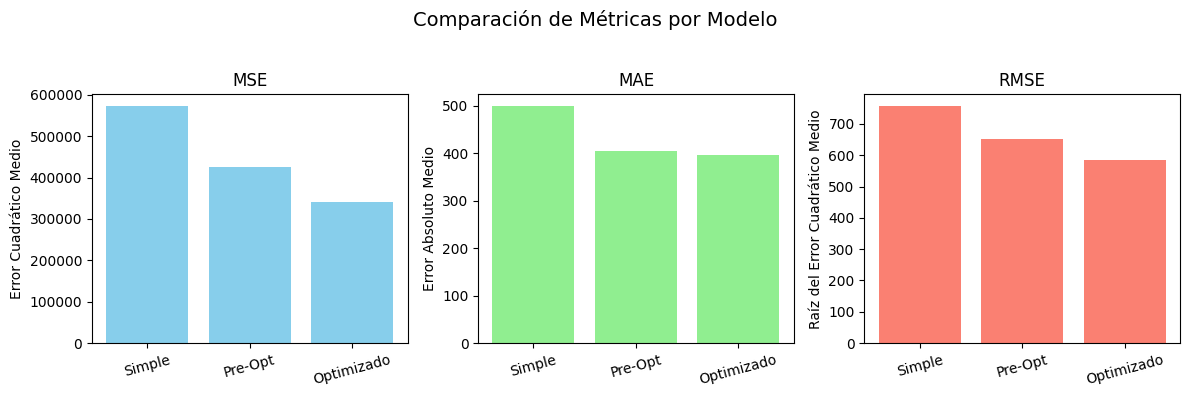

In [98]:
# Listas organizadas con las métricas
mse = [mse1, mse2, mse3]
mae = [mae1, mae2, mae3]
rmse = [rmse1, rmse2, rmse3]

# Crear la figura y los subgráficos
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
fig.suptitle("Comparación de Métricas por Modelo", fontsize=14)

# Modelos
modelos = ["Simple", "Pre-Opt", "Optimizado"]

# MSE
axes[0].bar(modelos, mse, color="skyblue")
axes[0].set_title("MSE")
axes[0].set_ylabel("Error Cuadrático Medio")

# MAE
axes[1].bar(modelos, mae, color="lightgreen")
axes[1].set_title("MAE")
axes[1].set_ylabel("Error Absoluto Medio")

# RMSE
axes[2].bar(modelos, rmse, color="salmon")
axes[2].set_title("RMSE")
axes[2].set_ylabel("Raíz del Error Cuadrático Medio")

# Ajustar etiquetas del eje x
for ax in axes:
    ax.set_xticklabels(modelos, rotation=15)

# Mostrar la gráfica
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()
